# 🌳 Day 1-2: 트리 & 랜덤포레스트 회귀

선형 회귀 모델이 데이터의 선형 관계를 가정하는 반면, 트리 기반 모델은 데이터를 작은 그룹으로 반복적으로 분할하여 예측을 수행합니다. 

마치 '스무고개' 놀이처럼, 특정 질문(조건)에 따라 데이터를 나누어 복잡한 패턴도 학습할 수 있는 강력한 모델입니다.

오늘은 가장 대표적인 트리 모델인 **결정 트리(Decision Tree)** 와 이의 한계를 극복한 앙상블 모델인 **랜덤 포레스트(Random Forest)** 에 대해 깊이 있게 학습합니다.

---

### **1. 결정 트리 회귀 (Decision Tree Regressor)**

결정 트리는 데이터를 가장 잘 나눌 수 있는 질문(특성)을 순차적으로 찾아가며 예측 모델을 만드는 알고리즘입니다.

#### **1.1. 개념: 스무고개처럼 데이터를 나누는 모델**

결정 트리는 특정 지점에서 데이터를 두 영역으로 나누는 '결정 경계(Decision Boundary)'를 반복적으로 만들어 예측을 수행합니다. 

회귀 문제의 경우, 각 분할은 예측 오차(예: 평균제곱오차, MSE)를 가장 많이 줄일 수 있는 방향으로 이루어집니다.

* **루트 노드 (Root Node):** 예측을 시작하는 최상위 노드. 전체 데이터를 포함합니다.
  
* **중간 노드 (Internal Node):** 데이터를 특정 기준으로 분할하는 중간 단계의 노드.
* **리프 노드 (Leaf Node):** 더 이상 분할되지 않는 최종 노드. 이 노드에 속한 데이터들의 타겟 변수 평균값이 해당 노드의 최종 예측값이 됩니다.
* **깊이 (Depth):** 루트 노드에서 특정 노드까지 도달하는 데 거치는 분할의 횟수.

예를 들어 '자전거 대여량'을 예측한다면, 결정 트리는 아래와 같은 질문을 통해 예측값을 찾아갑니다.
1.  기온이 10도 이상인가? (Yes/No)
   
2.  (Yes일 경우) 습도가 60% 미만인가? (Yes/No)
3.  (Yes일 경우) 풍속이 2m/s 미만인가? (Yes/No)
...
최종적으로 도달한 **리프 노드**에 속한 데이터들의 평균 대여량이 예측 결과가 됩니다.

#### **1.2. 핵심 개념: 편향-분산 트레이드오프 (Bias-Variance Tradeoff)**

결정 트리는 **깊이(`max_depth`)** 를 제한하지 않으면 훈련 데이터에 과도하게 최적화되는 **과적합(Overfitting)** 경향이 매우 강합니다.

* **깊은 트리 (High Depth):** 훈련 데이터의 아주 작은 노이즈까지 학습하여 복잡한 모델을 만듭니다. 이로 인해 **편향(Bias)은 낮아지지만 분산(Variance)은 높아져**, 새로운 데이터에 대한 예측 성능이 떨어집니다. (훈련 데이터 점수는 높지만, 테스트 데이터 점수는 낮은 상태)
* **얕은 트리 (Low Depth):** 모델이 너무 단순하여 데이터의 복잡한 패턴을 충분히 학습하지 못합니다. **편향은 높아지고 분산은 낮아져** 과소적합(Underfitting)이 발생합니다.

`max_depth`, `min_samples_leaf`와 같은 하이퍼파라미터를 조절하여 모델의 복잡도를 제어하고 편향과 분산의 균형을 맞추는 것이 중요합니다.

* 구글 스프레드시트로 Decision Tree 회귀 모델 이해하기 : [링크](https://docs.google.com/spreadsheets/d/14JRl5jT3du75GD_maZH-VSyeEBVUfA-qYzgLUP012JI/edit?usp=sharing)


#### **1.3. 코드 실습: 서울시 따릉이 수요 예측**

이제 코드를 통해 서울시 공공자전거(따릉이) 데이터를 이용해 결정 트리 회귀 모델을 만들어 보겠습니다.

**데이터셋 정보**
* **출처:** [Seoul Bike Sharing Demand Prediction (Kaggle)](https://www.kaggle.com/datasets/saurabhshahane/seoul-bike-sharing-demand-prediction)
* **내용:** 시간대별 기온, 습도 등 날씨 정보와 해당 시간의 자전거 대여량(`Rented Bike Count`) 정보 포함

##### **1.3.1. 데이터 준비 및 전처리**

먼저 필요한 라이브러리를 불러오고 데이터를 준비합니다. 범주형 변수는 모델이 이해할 수 있도록 원-핫 인코딩(One-hot Encoding)으로 변환합니다.

In [2]:
# 데이터 전처리 라이브러리 준비
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
# 시각화 관련 라이브러리 준비
import koreanize_matplotlib
koreanize_matplotlib.koreanize()
import plotly.express as px
import matplotlib.pyplot as plt
pd.options.plotting.backend = 'plotly'
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 데이터셋 로드 (cp949 인코딩이 필요합니다.)
# 로컬/도커 경로에 맞게 수정해주세요.
df = pd.read_csv('../datasets/ml/bike-sharing/SeoulBikeData.csv', encoding='cp949')

In [5]:
# 날짜(Date) 컬럼을 datetime 형식으로 변환하고, 월/일/요일 특성 추출
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.dayofweek
df.head()

,Date,Rented Bike Count,Hour,Temperature(캜),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(캜),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Month,Day,Weekday
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,4
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,4
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,4
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,4
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,4


In [6]:
# 범주형 변수 원-핫 인코딩
df = pd.get_dummies(df, columns=['Seasons', 'Holiday', 'Functioning Day'], drop_first=True) # 첫번째는 중복된 정보기 때문에 제거거
df.head()

,Date,Rented Bike Count,Hour,Temperature(캜),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(캜),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Month,Day,Weekday,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Functioning Day_Yes
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,12,1,4,False,False,True,True,True
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,12,1,4,False,False,True,True,True
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,12,1,4,False,False,True,True,True
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,12,1,4,False,False,True,True,True
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,12,1,4,False,False,True,True,True


In [7]:
# 원본 날짜 컬럼 및 불필요한 컬럼 제거
df_processed = df.drop(['Date'], axis=1)

# 특성(X)과 타겟(y) 분리
X = df_processed.drop('Rented Bike Count', axis=1)
y = df_processed['Rented Bike Count']

# 훈련/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('훈련 데이터셋 크기:', X_train.shape)
print('테스트 데이터셋 크기:', X_test.shape)

훈련 데이터셋 크기: (7008, 17)
테스트 데이터셋 크기: (1752, 17)


##### **1.3.2. 모델 학습 및 평가**

`max_depth=5`로 설정하여 트리의 복잡도를 제한하고 과적합을 방지해 보겠습니다. 

모델의 성능은 **RMSE(Root Mean Squared Error)**로 평가합니다. 

RMSE는 실제값과 예측값의 차이를 제곱하여 평균낸 값의 제곱근으로, 오차를 실제값과 같은 단위로 해석할 수 있게 해줍니다.

$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$

In [8]:
# RMSE 계산 함수 정의
rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

In [9]:
from sklearn.tree import DecisionTreeRegressor

# 결정 트리 회귀 모델 생성 및 학습 (max_depth=5)
tree_reg = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_reg.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred_tree = tree_reg.predict(X_test) # 대여량 중간 예측

# RMSE 계산
rmse_tree = rmse(y_test, y_pred_tree)
print(f'결정 트리 (max_depth=5) RMSE: {rmse_tree:.2f}')

결정 트리 (max_depth=5) RMSE: 355.47


##### **1.3.3. 트리시각화**

`plot_tree` 함수를 사용해 학습된 트리의 구조를 직접 확인할 수 있습니다. 

이를 통해 모델이 어떤 기준으로 데이터를 분할하는지 직관적으로 이해할 수 있습니다.

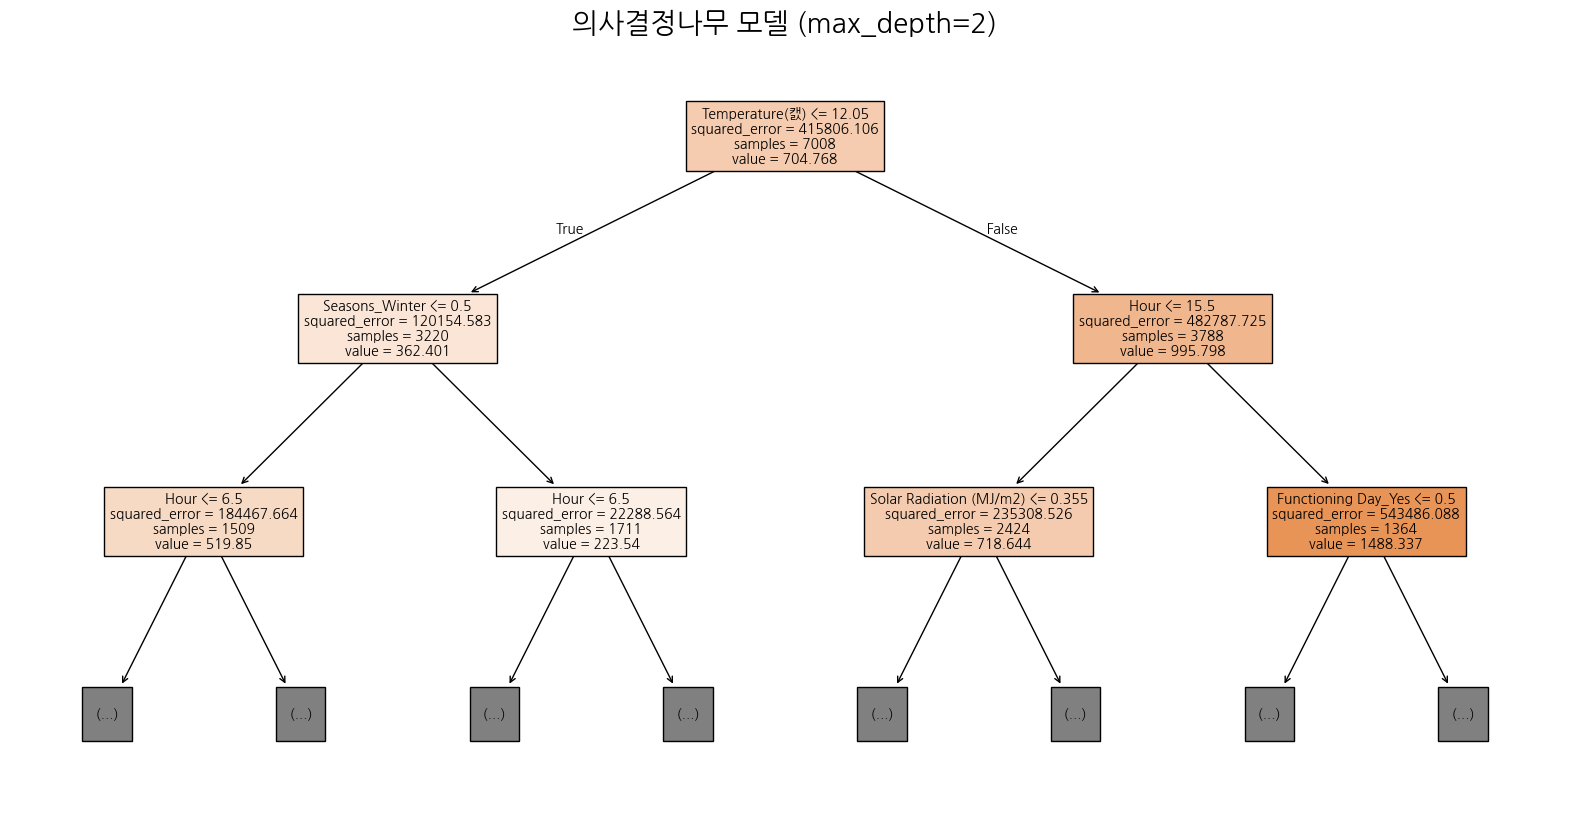

In [10]:
# 의사결정트리 시각화 내장 함수
from sklearn.tree import plot_tree
# 트리 시각화 (깊이가 깊으면 매우 복잡해지므로 max_depth를 작게 설정)
plt.figure(figsize=(20, 10))
plot_tree(tree_reg,
          feature_names=X.columns.tolist(),
          filled=True,
          fontsize=10,
          max_depth=2) # 시각화를 위해 처음 2단계 깊이만 표시
plt.title("의사결정나무 모델 (max_depth=2)", fontsize=20)
plt.show()

# 엔트로피 대신 mse를 낮춤

##### **1.3.4. 특성 중요도(Feature Importance)**

트리 모델의 특성 중요도는 각 특성이 예측 성능에 미치는 영향을 측정하는 지표입니다. 

중요도가 높은 특성은 모델의 예측 성능에 큰 영향을 미치는 특성으로, 모델 해석에 유용합니다.

트리 계열 모델에서 특성 중요도는 각 특성이 불순도(impurity) 감소에 얼마나 기여하는지를 측정하여 계산됩니다.

**특성 중요도 계산 방법**
1. **불순도 감소량 계산**: 각 노드에서 분할할 때 불순도가 얼마나 감소하는지 측정
   
2. **가중 평균**: 각 노드의 샘플 수에 비례하여 가중 평균을 계산
3. **정규화**: 모든 특성의 중요도 합이 1이 되도록 정규화

**수식:**
- 특성 j의 중요도 = Σ (해당 특성으로 분할된 노드의 불순도 감소량 × 노드의 샘플 비율)
  
- 회귀 문제에서는 MSE(평균제곱오차) 감소량을 사용
- 분류 문제에서는 지니 불순도나 엔트로피 감소량을 사용

**해석:**
- 값이 클수록 해당 특성이 예측에 더 중요한 역할을 함
  
- 모든 특성의 중요도 합은 1.0
- 트리의 상위 노드에서 사용된 특성일수록 높은 중요도를 가짐

**특성 중요도 활용 사례**
1. **특성 선택(Feature Selection)**: 중요도가 낮은 특성들을 제거하여 모델을 단순화하고 과적합을 방지
   
2. **도메인 이해**: 비즈니스 관점에서 어떤 요인이 결과에 가장 큰 영향을 미치는지 파악
3. **데이터 수집 우선순위**: 새로운 데이터를 수집할 때 중요한 특성에 더 많은 자원을 투입
4. **모델 해석**: 블랙박스 모델의 예측 근거를 설명하여 신뢰성 확보
5. **A/B 테스트 설계**: 중요한 특성을 기반으로 실험 변수 설정
6. **이상치 탐지**: 중요한 특성에서 비정상적인 값을 가진 데이터 포인트 식별


In [11]:
# Plotly를 사용한 트리 시각화
import plotly.graph_objects as go
from sklearn.tree import export_text

# 트리 구조를 텍스트로 출력
tree_rules = export_text(tree_reg, 
                        feature_names=X.columns.tolist(),
                        max_depth=3)  # 가독성을 위해 깊이 제한

print("결정 트리 구조:")
print(tree_rules)

# 특성 중요도를 Plotly로 시각화
feature_importance = tree_reg.feature_importances_
feature_names = X.columns.tolist()

# 중요도가 높은 순으로 정렬
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# Plotly 막대 그래프로 특성 중요도 시각화
fig = go.Figure(go.Bar(
    x=importance_df['importance'],
    y=importance_df['feature'],
    orientation='h',
    marker=dict(color='lightblue', line=dict(color='darkblue', width=1))
))

fig.update_layout(
    title='결정 트리 특성 중요도',
    xaxis_title='중요도',
    yaxis_title='특성',
    height=600,
    width=800,
    font=dict(size=12)
)

fig.show()

결정 트리 구조:
|--- Temperature(캜) <= 12.05
|   |--- Seasons_Winter <= 0.50
|   |   |--- Hour <= 6.50
|   |   |   |--- Hour <= 1.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- Hour >  1.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- Hour >  6.50
|   |   |   |--- Humidity(%) <= 80.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- Humidity(%) >  80.50
|   |   |   |   |--- truncated branch of depth 2
|   |--- Seasons_Winter >  0.50
|   |   |--- Hour <= 6.50
|   |   |   |--- Hour <= 2.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- Hour >  2.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- Hour >  6.50
|   |   |   |--- Temperature(캜) <= 3.85
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- Temperature(캜) >  3.85
|   |   |   |   |--- truncated branch of depth 2
|--- Temperature(캜) >  12.05
|   |--- Hour <= 15.50
|   |   |--- Solar Radiation (MJ/m2) <= 0.36
|   |   |   |--- Hour <= 1.5

#### **1.4. 연습문제**

**문제 1: `max_depth` 변화에 따른 성능 비교**

`DecisionTreeRegressor`의 `max_depth`를 10으로 설정하여 모델을 새로 학습시키고, `max_depth=5`일 때의 RMSE와 비교해보세요. `max_depth`가 깊어지면 RMSE는 어떻게 변하나요?

In [12]:
# 코드 작성
tree_reg2 = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_reg2.fit(X_train, y_train)

y_pred_tree2 = tree_reg2.predict(X_test)

rmse_tree2 = rmse(y_test, y_pred_tree2)

print(f'결정 트리 (max_depth=10) RMSE: {rmse_tree2:.2f}')

결정 트리 (max_depth=10) RMSE: 249.90


**문제 2: `min_samples_leaf`의 효과**

`min_samples_leaf`는 리프 노드가 되기 위해 필요한 최소한의 샘플 개수를 지정하는 하이퍼파라미터입니다. 이 값을 늘리면 모델이 더 단순해져 과적합을 방지하는 효과가 있습니다. `max_depth=None` (제한 없음)으로 두고, `min_samples_leaf`를 1, 10, 50으로 변경하며 훈련/테스트 RMSE를 각각 계산하고 비교해보세요.

In [13]:
# 코드 작성



#### **1.5. 연습문제 정답**

**정답 1:**

In [14]:
# 문제 1 정답 코드
tree_reg_10 = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_reg_10.fit(X_train, y_train)
y_pred_10 = tree_reg_10.predict(X_test)
rmse_10 = np.sqrt(mean_squared_error(y_test, y_pred_10))

print(f'결정 트리 (max_depth=5) RMSE: {rmse_tree:.2f}')
print(f'결정 트리 (max_depth=10) RMSE: {rmse_10:.2f}')
# max_depth가 깊어지면 훈련 데이터에 더 적합하게 되어 테스트 데이터에 대한 RMSE가 개선될 수 있지만,
# 특정 깊이 이상에서는 과적합으로 인해 오히려 성능이 저하될 수 있습니다.

결정 트리 (max_depth=5) RMSE: 355.47
결정 트리 (max_depth=10) RMSE: 249.90


**정답 2:**

In [15]:
# 문제 2 정답 코드
leaf_options = [1, 10, 50]
for n_leaf in leaf_options:
    tree_reg_leaf = DecisionTreeRegressor(max_depth=None, min_samples_leaf=n_leaf, random_state=42)
    tree_reg_leaf.fit(X_train, y_train)

    # 훈련 데이터 성능
    y_pred_train = tree_reg_leaf.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    # 테스트 데이터 성능
    y_pred_test = tree_reg_leaf.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    print(f'min_samples_leaf={n_leaf}:')
    print(f'  - 훈련 RMSE: {rmse_train:.2f}')
    print(f'  - 테스트 RMSE: {rmse_test:.2f}\n')

# min_samples_leaf=1 일 때 훈련 RMSE는 0에 가깝게 나오지만(완벽한 과적합), 테스트 RMSE는 매우 높습니다.
# 이 값을 증가시킬수록 훈련 RMSE는 높아지고(과소적합 방향), 테스트 RMSE는 특정 지점까지 낮아지다가 다시 높아지는 경향을 보입니다.

min_samples_leaf=1:
  - 훈련 RMSE: 0.00
  - 테스트 RMSE: 246.52

min_samples_leaf=10:
  - 훈련 RMSE: 173.48
  - 테스트 RMSE: 249.27

min_samples_leaf=50:
  - 훈련 RMSE: 261.99
  - 테스트 RMSE: 301.93



---

### **2. 랜덤 포레스트 회귀 (Random Forest Regressor)**

랜덤 포레스트는 **앙상블(Ensemble)** 기법 중 하나인 **배깅(Bagging)**을 기반으로 한 모델입니다. 성능이 조금씩 다른 여러 개의 결정 트리를 만들어 그 예측 결과를 종합(평균)하여 최종 예측값을 결정합니다.

#### **2.1. 개념: 집단 지성의 힘, 앙상블**

혼자서는 불안정한 결정 트리의 가장 큰 단점은 **높은 분산**, 즉 과적합 경향입니다. 랜덤 포레스트는 이 문제를 해결하기 위해 두 가지 '무작위' 요소를 추가합니다.

1.  **부트스트랩 샘플링 (Bootstrap Sampling):** 원본 훈련 데이터에서 중복을 허용하여 여러 개의 서브-데이터셋을 만듭니다. 각 결정 트리는 서로 다른 서브-데이터셋으로 학습됩니다.
2.  **특성 무작위 선택 (Random Feature Selection):** 각 노드를 분할할 때, 전체 특성 중 일부만 무작위로 선택하여 최적의 분할 기준을 찾습니다.

이렇게 만들어진 수백 개의 **다양성을 갖춘** 트리들의 예측 결과를 평균내어, 단일 트리보다 훨씬 안정적이고 정확한 예측을 만들어냅니다. 이는 '집단 지성'의 원리와 같습니다.

#### **2.2. 코드 실습: 결정 트리보다 강력한 성능**

동일한 데이터에 랜덤 포레스트 모델을 적용하고 결정 트리와 성능을 비교해 보겠습니다. `n_estimators`는 생성할 트리의 개수를 의미합니다.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 랜덤 포레스트 모델 생성 및 학습 (n_estimators=100) - 의사결정 나무를 100개 정도 만들어서 학습 (기본값 100)
# n_jobs=-1 은 사용 가능한 모든 CPU 코어를 사용하여 학습 속도를 높입니다.
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred_rf = rf_reg.predict(X_test)

# RMSE 계산
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f'결정 트리 (max_depth=5) RMSE: {rmse_tree:.2f}')
print(f'랜덤 포레스트 RMSE: {rmse_rf:.2f}')

결정 트리 (max_depth=5) RMSE: 355.47
랜덤 포레스트 RMSE: 172.35


보통의 경우, 랜덤 포레스트는 단일 결정 트리보다 훨씬 낮은 RMSE(더 좋은 성능)를 보입니다.

#### **2.3. 핵심 기능: 특성 중요도 (Feature Importance)**

랜덤 포레스트의 또 다른 강력한 기능은 의사결정트리와 마찬가지로 **특성 중요도** 를 제공한다는 점입니다. 

모델이 예측을 수행할 때 어떤 특성(변수)을 더 중요하게 사용했는지 정량적으로 확인할 수 있습니다. 

이는 모델을 해석하고 비즈니스 인사이트를 도출하는 데 매우 유용합니다.

In [17]:
# 특성 중요도 추출
importances = rf_reg.feature_importances_
feature_names = X_train.columns

# 특성 중요도를 DataFrame으로 변환
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 특성 중요도 시각화
fig = px.bar(feature_importance_df.head(15),
             x='Importance',
             y='Feature',
             orientation='h',
             title='Top 15 Feature Importances in Random Forest')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

위 시각화를 통해 'Hour'(시간), 'Temperature(°C)'(기온), 'Humidity(%)'(습도) 등이 따릉이 대여량을 예측하는 데 중요한 변수임을 알 수 있습니다.


#### **2.4. 연습문제**

**문제 1: `n_estimators` 변화에 따른 성능 및 시간**

`n_estimators` 값을 10, 50, 200으로 변경하며 랜덤 포레스트를 학습시키고, 각각의 RMSE와 학습 시간을 비교해보세요. 트리의 개수가 늘어날수록 성능은 어떻게 변하나요?

In [24]:
# 코드 작성
from sklearn.ensemble import RandomForestRegressor

# 랜덤 포레스트 모델 생성 및 학습 (n_estimators=100) - 의사결정 나무를 100개 정도 만들어서 학습 (기본값 100)
# n_jobs=-1 은 사용 가능한 모든 CPU 코어를 사용하여 학습 속도를 높입니다.
n_es_list = [10, 50, 100]

for n in n_es_list:
    rf_reg = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
    rf_reg.fit(X_train, y_train)

    # 테스트 데이터 예측
    y_pred_rf = rf_reg.predict(X_test)

    # RMSE 계산
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

    print(f'랜덤 포레스트_{n} RMSE: {rmse_rf:.2f}')

# 잔차가 줄어듬 -> 성능 향상

랜덤 포레스트_10 RMSE: 189.00
랜덤 포레스트_50 RMSE: 172.70
랜덤 포레스트_100 RMSE: 172.35


**문제 2: `max_features`의 역할**

`max_features`는 각 노드 분할 시 무작위로 선택할 특성의 최대 개수를 지정합니다. 이 값을 조절하여 트리의 다양성을 제어할 수 있습니다. `max_features`를 `1.0` (모든 특성 사용, 배깅 방식), `0.5` (특성의 50% 사용), `'sqrt'` (특성 개수의 제곱근 사용, 기본값)로 설정하여 모델을 학습하고 성능을 비교해보세요.

In [ ]:
# 코드 작성
# max_features 기본값 1.0
feature_options = [1.0, 0.5, 'sqrt']
for max_feat in feature_options:
    rf_reg_feat = RandomForestRegressor(n_estimators=100, max_features=max_feat, random_state=42, n_jobs=-1)
    rf_reg_feat.fit(X_train, y_train)

    y_pred_feat = rf_reg_feat.predict(X_test)
    rmse_feat = np.sqrt(mean_squared_error(y_test, y_pred_feat))

    print(f'max_features={max_feat} RMSE : {rmse_feat:.2f}')

max_features=1.0 RMSE : 172.35
max_features=0.5 RMSE : 176.27
max_features=sqrt RMSE : 201.26



#### **2.5. 연습문제 정답**

**정답 1:**

In [20]:
import time

# 문제 1 정답 코드
estimator_options = [10, 50, 200]
for n_est in estimator_options:
    start_time = time.time()
    rf_reg_est = RandomForestRegressor(n_estimators=n_est, random_state=42, n_jobs=-1)
    rf_reg_est.fit(X_train, y_train)
    end_time = time.time()

    y_pred_est = rf_reg_est.predict(X_test)
    rmse_est = np.sqrt(mean_squared_error(y_test, y_pred_est))

    print(f'n_estimators={n_est}:')
    print(f'  - RMSE: {rmse_est:.2f}')
    print(f'  - 학습 시간: {end_time - start_time:.2f}초\n')

# n_estimators가 증가할수록 일반적으로 성능이 안정되고 개선되는 경향이 있지만,
# 일정 수준 이상부터는 성능 향상 폭이 미미하고 학습 시간만 길어질 수 있습니다.

n_estimators=10:
  - RMSE: 189.00
  - 학습 시간: 0.12초

n_estimators=50:
  - RMSE: 172.70
  - 학습 시간: 0.47초

n_estimators=200:
  - RMSE: 172.98
  - 학습 시간: 1.67초



**정답 2:**

In [21]:
# 문제 2 정답 코드
feature_options = [1.0, 0.5, 'sqrt']
for max_feat in feature_options:
    rf_reg_feat = RandomForestRegressor(n_estimators=100, max_features=max_feat, random_state=42, n_jobs=-1)
    rf_reg_feat.fit(X_train, y_train)

    y_pred_feat = rf_reg_feat.predict(X_test)
    rmse_feat = np.sqrt(mean_squared_error(y_test, y_pred_feat))

    print(f'max_features={max_feat}:')
    print(f'  - RMSE: {rmse_feat:.2f}\n')

# max_features=1.0 이면 각 트리가 모든 특성을 고려하므로 트리의 다양성이 줄어듭니다.
# 'sqrt'나 0.5 처럼 특성을 제한하면 각 트리가 다른 관점에서 데이터를 학습하게 되어
# 앙상블 효과가 극대화되고 일반화 성능이 좋아지는 경우가 많습니다.

max_features=1.0:
  - RMSE: 172.35

max_features=0.5:
  - RMSE: 176.27

max_features=sqrt:
  - RMSE: 201.26

